# Environment Dynamics

An example on how to compute the dynamics of a gaussian bosonic environment using the OQuPy package.

First let's import the necessary packages

In [1]:
import sys
sys.path.insert(0,'..')
import oqupy
import matplotlib.pyplot as plt
import numpy as np

and define the necessary spin matrices for convenience

In [2]:
spin_down = oqupy.operators.spin_dm("down")
s_z = 0.5*oqupy.operators.sigma("z")
s_x = 0.5*oqupy.operators.sigma("x")

## Example - Heat transfer in a biased spin-boson model
Let's try and recreate a line cut of Figure 2 from [Gribben2021] ([arXiv:2106.04212](https://arxiv.org/abs/2106.04212)). This tells us how much heat has been emitted into or absorbed from the bath by the system and how this transfer is distributed over the bath modes.

### 1. Hamiltonian - Biased spin-boson model
The system Hamiltonian we consider is:
$$H_S = \epsilon s_z + \Omega s_x$$
describing a spin-$\frac{1}{2}$ particle with energy splitting $\epsilon$ and transition frequency $\Omega$. Here $s_i = \sigma_i/2$ where $\sigma_i$ are the Pauli matrices.

The interaction Hamiltonian is given by:
$$H_I = {s_z} \sum_k g_k \left(a_k+a_k^\dagger\right),$$
and the bath Hamiltonian by:
$$H_B = \sum_k \omega_k a_k^\dagger a_k.$$
This describes a linear coupling to bosons of frequency $\omega_k$ with strength $g_k$. These bosons are described by the ladder operators $a_k$ and $a^\dagger_k$ which satisfy the canonical commutation relations:
$$ \left[a_k,a_{k'}^\dagger\right]=\delta_{kk'},$$
$$ \left[a_k,a_{k'}\right]=\left[a_k^\dagger,a_{k'}^\dagger\right] = 0.$$
We can characterise the bath entirely by its spectral density:
$$ J(\omega) = \sum_k |g_k|^2 \delta(\omega - \omega_k) = 2 \, \alpha \, \omega \, \exp\left(-\frac{\omega}{\omega_\mathrm{cutoff}}\right) \mathrm{,} $$
where we have decided on an Ohmic spectral density with dimensionless coupling strength $\alpha$ and high-frequency cutoff $\omega_c$.

Also, let's assume the initial density matrix of the spin is the down state
$$ \rho_S(0) = \begin{pmatrix} 0 & 0 \\ 0 & 1 \end{pmatrix} $$ and the bath is initially in thermal equilibrium at $T=\Omega$.

For the rest of the parameters we choose to set:

* $\epsilon = 2.0 \Omega$
* $\omega_c = 10.0 \Omega$
* $\alpha = 0.05$

### 2. Building the process tensor

The setting up of the system and general running of TEMPO/PT-TEMPO has been covered in detail in the previous tutorials so for now let us go right ahead and build a process tensor for this spectral density. Here we'll use much rougher convergence parameters than in the paper, the qualitative result is not really changed though.

In [3]:
Omega = 1
alpha = 0.05
w_cutoff = 10 * Omega
epsilon = 2 * Omega
dkmax = 10
epsrel = 1e-5
final_t = 20
delta_t = 0.2
initial_state = spin_down
corr = oqupy.PowerLawSD(alpha, 1, w_cutoff, temperature = 1)
pars = oqupy.TempoParameters(delta_t, dkmax, epsrel)
system = oqupy.System(Omega*s_x + epsilon*s_z)
bath = oqupy.Bath(s_z, corr)
pt = oqupy.PtTempo(bath, 0.0, final_t, pars)
pt = pt.get_process_tensor(progress_type='bar')

--> PT-TEMPO computation:
100.0%  100 of  100 [########################################] 00:00:03
Elapsed time: 3.1s


Now as we saw previously the process tensor can readily be used to calculate system dynamics, for example let's look at how the density matrix elements evolve.

--> Compute dynamics:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.3s


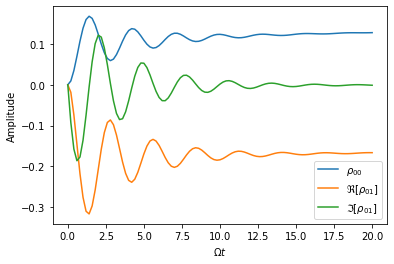

In [4]:
dyns = oqupy.contractions.compute_dynamics(
    system=system,
    initial_state=initial_state,
    process_tensor=pt)
times, states = dyns.times, dyns.states
plt.plot(times, states[:,0,0].real, label=r'$\rho_{00}$')
plt.plot(times, states[:,0,1].real, label=r'$\Re[\rho_{01}]$')
plt.plot(times, states[:,0,1].imag, label=r'$\Im[\rho_{01}]$')
plt.xlabel(r"$\Omega t$")
plt.ylabel(r"Amplitude")
plt.legend()

Already the process tensor tells us everything we could want to know about the system but actually we can infer a lot about how the bath behaves as well.

### 3. Bath dynamics

In [Gribben2021] ([arXiv:2106.04212](https://arxiv.org/abs/2106.04212)) we can see that for linearly coupled Gaussian environments the bath dynamics can be calculated through relatively simple transformations of system correlation functions. For example the change in energy of mode $k$ can be expressed as

$$ \omega_k\left\langle a_k^\dagger (t) a_k (t)-a_k^\dagger (0) a_k (0) \right\rangle = \omega_k g_k^2 \int_0^t dt' \int_0^t dt'' \left\langle s_z(t')s_z(t'')\right\rangle F(\omega_k, t', t'', T), $$
with
$$ F(\omega, t', t'', T) := \cos[\omega (t'-t'')]-i \sin[\omega(t'-t'')]\coth(\omega /2T). $$

However we typically take the continuum limit in which case the coupling to any single mode becomes infinitesimal and it makes more sense to talk about how heat is exchanged within a band of modes $(\omega-\delta/2,\omega+\delta/2)$. This gives us the expression:

$$ \Delta Q (\omega,t) = \int_{\omega-\delta/2}^{\omega+\delta/2}d\omega' \omega' J(\omega') \int_0^t dt' \int_0^t dt'' \left\langle s_z(t')s_z(t'')\right\rangle F(\omega', t', t'', T),$$
$$ \Delta Q (\omega,t) \approx  \omega J(\omega)\delta \int_0^t dt' \int_0^t dt'' \left\langle s_z(t')s_z(t'')\right\rangle F(\omega', t', t'', T),$$
where $\left\langle s_z(t')s_z(t'')\right\rangle =  \mathrm{Tr} [s_z(t')s_z(t'')\rho]$ and we have approximated the integrand as constant over the bandwidth. The validity of this is reliant on the system relaxing much faster than the timescale set by $\delta^{-1}$.

To be compatible with PT-TEMPO we must now discretise this expression according into timesteps, a rough discretisation can be expressed as:
$$\Delta Q (\omega,t_N) \approx  \omega J(\omega)\delta \sum_{k=0}^{N-1} \sum_{k'=0}^{N-1}  \left\langle s_z(t_k)s_z(t_{k'})\right\rangle F(\omega,t_k,t_{k'},T) \, dt^2.$$
Here $dt$ is the same timestep set as the convergence parameter in PT-TEMPO and we have defined timesteps $t_k = k dt$. In practice this discretisation breaks down at large $\omega$, the actual implementation does something slightly more sophisticated which will be detailed elsewhere.

To calculate this in OQuPy we begin by initialising a `TwoTimeBathCorrelations` object from the `bath_dynamics` module:

In [5]:
bath_corr = oqupy.bath_dynamics.TwoTimeBathCorrelations(system, bath, pt, initial_state)

As inputs this requires everything necessary to calculate the system correlation functions:
* `system`: the system Hamiltonian.
* `bath`: characterises bath containing information about its spectral density and temperature.
* `process_tensor`: the process tensor which when combined with the system Hamiltonian can be used to calculate any system correlation function.
* `initial_state`: the initial system density matrix which must be either built into the process tensor or input here.

We can now use the method `occupation` to calculate the energy dynamics of a particular mode by multiplying the output by its frequency, in this case let's look at `w = Omega` and a bandwidth of `delta = 0.1 * Omega`:

--> Compute correlations:
100.0%  100 of  100 [########################################] 00:00:15
Elapsed time: 15.6s


Text(0, 0.5, '$\\Delta Q ( \\Omega, t)$')

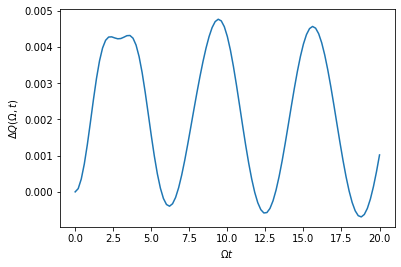

In [6]:
w = Omega
delta = 0.1 * Omega
tlist, occ = bath_corr.occupation(w, delta, change_only = True)
energy = w * occ
plt.plot(tlist,energy)
plt.xlabel(r'$\Omega t$')
plt.ylabel(r'$\Delta Q ( \Omega, t)$')

...that took quite a while. From the expression for $\Delta Q$ is would seem that to calculate the change in energy of the bath up to time $t_N$ requires the $N^2$ two-time system correlation functions. In fact we only need the $N(N+1)/2$ time-ordered correlation functions due to $\left\langle s_z(t_{k'})s_z(t_{k})\right\rangle = \left\langle s_z(t_{k})s_z(t_{k'})\right\rangle^*$. However, this can still be quite time-consuming to calculate, but let's see what happens if we want the energy of another mode now, let's say `w = 2 * Omega`

Text(0, 0.5, '$\\Delta Q (2 \\Omega, t)$')

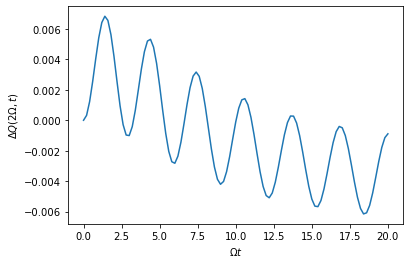

In [7]:
w = 2 * Omega
delta = 0.1 * Omega
tlist, occ = bath_corr.occupation(w, delta, change_only = True)
energy = w * occ
plt.plot(tlist, energy)
plt.xlabel(r'$\Omega t$')
plt.ylabel(r'$\Delta Q (2 \Omega, t)$')

Much quicker! This is because the same set of system correlation functions can be used to compute any bath correlation function $\langle \alpha_2(t_2)\alpha_1(t_1)\rangle$ where $\alpha_2, \alpha_1 \in \{a_k^\dagger,a_k\} $ and $t_1,t_2 < t_N$. So now we see the logic of having a bath_dynamics object, it allows us to conveniently store the calculated system correlation functions and re-use them as we like :)

### 4. Recreating Figure 2

Now we have all the tools necessary to recreate the study of total heat exchanged as a function of $\epsilon$. However, this would take a while as we would need a new set of correlation functions for each $\epsilon$. Here we will just look at the case where $\epsilon = 2\Omega$. We are only interested in the total heat exchanged over the process so simply look at the final value of $\Delta Q$.

Text(0, 0.5, 'Heat Exchanged$/\\Omega$')

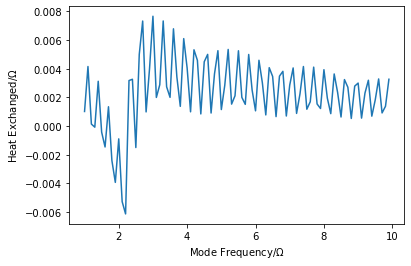

In [8]:
heat_list = []
freq_list = np.arange(1, 10, 0.1)
for w in freq_list:
    tlist, occ = bath_corr.occupation(w, 0.1, True)
    heat_list.append(w * occ[-1])
plt.plot(freq_list, heat_list)
plt.xlabel(r"Mode Frequency$/\Omega$")
plt.ylabel(r"Heat Exchanged$/\Omega$")

This is highly oscillatory, perhaps unsurprising from the dynamics we generated but still it would be nice to smooth this out. We expect the result to eventually equilibrate but with such a small bandwidth this will take a while, instead we simply period-average the result. The period at which each mode oscillates is $T(\omega)=2\pi/\omega$ so we average over the last $n$ timesteps where $(n+1) dt \geq T(\omega) > n dt$.

Text(0, 0.5, 'Heat Exchanged$/\\Omega$')

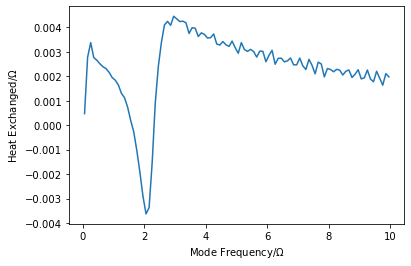

In [9]:
heat_list = []
freq_list = np.arange(0.05, 10, 0.1)
for w in freq_list:
    tlist, occ = bath_corr.occupation(w, 0.1, True)
    sel = tlist > (tlist[-1] - 2 * np.pi/w)
    energy = occ * w
    period_averaged_energy = np.mean(energy[sel])
    heat_list.append(period_averaged_energy)
plt.plot(freq_list, heat_list)
plt.xlabel(r"Mode Frequency$/\Omega$")
plt.ylabel(r"Heat Exchanged$/\Omega$")

Here, as in the paper, we see heat is absorbed by the system from the band of the modes in the vicinity of $\tilde{\Omega}=\sqrt{\Omega^2+\epsilon^2}$. This seems sensible as in a Markovian theory the system would sample the environment purely at its eigensplitting $\tilde{\Omega}$.

-------------------------------------------------